# Welcome to Augmentoolkit

This notebook is where you generate all your data.

Augmentoolkit is meant to allow instruct-tuned models to learn from books, even using themselves to generate new data through a sort-of bootstrapping method. It is meant to stop model creators from having to work as data annotators, and not actual model trainers. It is meant to allow anyone to make their own high-quality dataset with thousands of entries using cheap Open-Source APIs.

## Quickstart:

- Get this notebook and the other repo code onto a machine with an internet connection
- Paste your API key, favorite model name, and the endpoint URL of your preferred AI service, into the relevant constants located in the first code cell. Recommendation: [Together.ai with Hermes Mixtral works really nicely](https://api.together.xyz/playground/chat/NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO).
- Run all the cells below and watch as the notebook generates questions, answers, and conversations based on Principles of Chemistry and Simple Sabotage.

If you want to add your own texts, follow the instructions in list item #1 above.

### Note: this notebook makes roughly 1/3 characters generated to be **mildly NSFW** by default. You will need to modify the character personality code in `./generation_functions/special_instructions.py` or use "Assistant mode" if you want something cleaner.

## Customization:
### Here are some ways you can adapt this notebook to your use case, along with a brief description of how to do so, arranged in increasing order of difficulty (this information is also available in the README):
1. ***Change the source texts used to generate training data.*** You can do this in the cell right below this one. **IMPORTANT** the filenames of these should be formatted in a specific way, since the filenames are used as part of the prompts and in at least one regex. You need to have them be like: `[textname], by authorname`. You can also include the publication date after the author name if you want, but note that this will tend to bias most of the characters to live in the era of the textbook, which may or may not be what you want.

2. ***Change the personalities of the characters generated.*** Currently, when generating characters for the multiturn conversation step, three randomly-selected traits are appended to the "special instructions" set of the prompt to constrain what kind of character is generated by the model. Depending on what kind of model you want to make, or even just if your preferences vary, then you will probably want to modify this a bit. You can do so in `./generation_functions/special_instructions.py`. A more in-depth description of the trait-axis system that I (over)thought up is available in the comments of that file.

3. ***Change the constants.*** There are a few constant values in this notebook, and in `./generation_functions/constant_values.py`. These constants are tested, but if your use case requires special settings (e.g., you want to make conversations from more permutations of existing questions; or you think the character counts for the "duplicate question/answer" validation functions are too restrictive) then feel free to change the related setting. The most intuitive and least-likely-to-break-anything settings to change are rearrangements_to_take and double_check_counter. Beyond that... you'll need to figure out what the function does before changing it if you expect it to run.

4. ***Assistant Mode*** Technically this could be considered part of 3), but it's different enough that I feel it warrants separate explanation. By default, the notebook is configured to produce RP-style data; "Assistant mode" is something you can toggle in the settings cell immediately below this one, which skips character and scenario generation and answers every question in a chat between a user and a helpful AI assistant (with no personality). This can be handled by smaller models, so if your budget or time are very limited, or you are using this for a more professional use case, feel free to turn this on.

5. ***Change the model.*** This is as simple as switching the LOGICAL_MODEL value out for another one, but your mileage may vary significantly. My personal recommendation is to use [Hermes Mixtral DPO](https://api.together.xyz/playground/chat/NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO) for both models. You need at least 12k context on your model, and APIs typically don't allow RoPE scaling, so you're probably limited to MistralAI models here (or, heavens forbid, OpenAI. But GPT-4.5 + Augmentoolkit will BANKRUPT you fast, so be wary).

6. ***Change the examples.*** If you change the examples you can completely overhaul what this notebook does, but this requires a lot of prompting skill and possibly huge amounts of time to get it working again (source: most of my last three months were spent prompting, and most of this prompting was spent on the examples). Unless you want to convert this notebook from question-and-answer generation to some completely other task, I'd recommend changing only the conversation generation prompts -- they're a bit less finnicky, and if you just want to change the kind of characters generated (maybe you want a different writing style) that's where you'd find the differences.



## NOTE
You will want to turn off USE_SUBSET if you are doing a proper run over an entire text. It's on by default so you can iterate faster in the preparatory stages of dataset generation (and so that you can see the magic happen faster when you first use Augmentoolkit :) )

In [1]:
# NOTE NOTEBOOK SETTINGS AND CONSTANTS (some script file constants are in generation_functions/constants.py)

# Put your desired quant of your desired model in the relevant directories

import logging
import yaml


with open("./config.yaml",'r') as f:
    config = yaml.safe_load(f)

# "airoboros-l2-70b-3.1.2.Q4_K_M.gguf" <- recommended for the large logical model
# "flatorcamaid-13b-v0.2.Q8_0.gguf" <- recommended for the normal logical model
# A6000s on Vast.ai are a good choice for running this notebook

LOGICAL_MODEL = config["API"]["LOGICAL_MODEL"]

LARGE_LOGICAL_MODEL = config["API"]["LARGE_LOGICAL_MODEL"]

ASSISTANT_MODE = config["SYSTEM"]["ASSISTANT_MODE"]  # change to true if you want all conversations to be with an "AI language model" and not characters. Useful for more professional use cases.

DOUBLE_CHECK_COUNTER = config["SYSTEM"]["DOUBLE_CHECK_COUNTER"]  # Set to 1 to check outputs only once; set to 2 to check twice; set to 3 to check thrice, etc. Set to 0 to break everything in vet_question_loop() and elsewhere. Set to -1 and cause the universe to implode?

USE_SUBSET = config["SYSTEM"]["USE_SUBSET"] # Set to True if you want to use only a small subset of the text, to test whether it plays nicely with the current setup of the notebook

REARRANGEMENTS_TO_TAKE = config["SYSTEM"]["REARRANGEMENTS_TO_TAKE"] # How many of the possible permutations of tuples in a group to take and make multiturn convs out of. Adjust higher to get more data out of less text, but it might be a bit repetitive. NOTE your eval loss will be basically worthless if you aren't careful with how you shuffle your dataset when you're about to train.

USE_FILENAMES = config["SYSTEM"]["USE_FILENAMES"] # Turn on if you want the model to use the names of your files as additional context (this is what original Augmentoolkit does). Useful if you have a small number of large input files grouped by subject matter, IE books. Turn off if you have a large number of files with meaningless names.

CONCURRENCY_LIMIT = config["SYSTEM"]["CONCURRENCY_LIMIT"]  # Adjust this number based on the rate limit constraints of your api

API_KEY = config["API"]["API_KEY"]

BASE_URL = config["API"]["BASE_URL"]# Augmentoolkit-API should also be compatible with any other API provider that accepts OAI-style requests

COMPLETION_MODE = config["SYSTEM"]["COMPLETION_MODE"]

LOG_LEVEL = logging.INFO

source_texts = [ # add your texts here
    "./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944.txt",
]

## Below: Defines and imports functions that you will probably use no matter what cells in the notebook you choose to run:

In [2]:
import os
import uuid

# This is in no way best practices, but all my prompts being searchable and separate files is a good way to make my life easier.
import pkgutil
import importlib
import sys
from tqdm import asyncio as tqdmasyncio
import asyncio

# Set up rate-limit-conscious functions
semaphore = asyncio.Semaphore(CONCURRENCY_LIMIT)

async def run_task_with_limit(task):
    async with semaphore:
        # Run your task here
        return await task


# We have to define this up here so that two-step generation works, you'll see later.
multi_turn_convs_info_dir = "./multi_turn_convs_info"  # we generate all the information fed to the multiturn prompt, and generate the actual multiturn prompt, separately; since every step but the last is capable of being done by a 13b

sys.path.append("./generation_functions")
sys.path.append("./control_flow_functions")

import augmentoolkit.generation_functions as generation_functions  # This is the package directory
from augmentoolkit.control_flow_functions import control_flow_functions

# First, import all modules so they can be reloaded
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    importlib.import_module(module_name)

# Now, reload each module and import all callable attributes
for _, module_name, _ in pkgutil.iter_modules(
    generation_functions.__path__, generation_functions.__name__ + "."
):
    # Reload the module
    module = importlib.reload(sys.modules[module_name])
    # Iterate through each attribute in the reloaded module
    for attribute_name in dir(module):
        # Retrieve the attribute
        attribute = getattr(module, attribute_name)
        if callable(attribute):
            # If it's callable, it's a function or class, so you set it in the globals dictionary
            globals()[attribute_name] = attribute

In [3]:
# Initialize API Client
engine_wrapper = EngineWrapper(model=LOGICAL_MODEL,api_key=API_KEY,base_url=BASE_URL)

In [4]:
from transformers import AutoTokenizer
import re
from tqdm import tqdm
import nltk

nltk.download("punkt")
from nltk.tokenize import sent_tokenize

tokenizer = AutoTokenizer.from_pretrained(
    "Gryphe/MythoMax-L2-13b"
)  # It doesn't matter what model goes here, really

sentence_chunks = []
for source_text in source_texts:
    sentence_chunks += control_flow_functions.sentence_chunking_algorithm(source_text, tokenizer)

conversions = [("\n", " "), ("  ", " ")]

paragraphs_processed = [
    (control_flow_functions.fix_text(conversions, seq[0]), seq[1]) for seq in sentence_chunks
]

[nltk_data] Downloading package punkt to /Users/evan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Processing ./raw_txt_input/Simple Sabotage, by the Office of Strategic Services, published 1944.txt: 100%|██████████| 603/603 [00:00<00:00, 13279.87it/s]


#### Inspect various features of the text you have fed in to see if it came out alright-ish

In [5]:
len(paragraphs_processed)

52

In [6]:
paragraphs_processed[0]

('\ufeffThe Project Gutenberg eBook of Simple Sabotage Field Manual   This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. Title: Simple Sabotage Field Manual  Author: United States. Office of Strategic Services Release date: August 4, 2008 [eBook #26184]         Most recently updated: February 28, 2022 Language: English    [Illustration]   Simple Sabotage Field Manual Office of Strategic Services   OSS REPRODUCTION BRANCH SIMPLE SABOTAGE FIELD MANUAL Strategic Services (Provisional) STRATEGIC SERVICES FIELD MANUAL No. 3   Office of Strategic Services Washington, D. C. 17 January 1944  This Simple Sabot

In [7]:
print(paragraphs_processed[:3])

[('\ufeffThe Project Gutenberg eBook of Simple Sabotage Field Manual   This ebook is for the use of anyone anywhere in the United States and most other parts of the world at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this ebook or online at www.gutenberg.org. If you are not located in the United States, you will have to check the laws of the country where you are located before using this eBook. Title: Simple Sabotage Field Manual  Author: United States. Office of Strategic Services Release date: August 4, 2008 [eBook #26184]         Most recently updated: February 28, 2022 Language: English    [Illustration]   Simple Sabotage Field Manual Office of Strategic Services   OSS REPRODUCTION BRANCH SIMPLE SABOTAGE FIELD MANUAL Strategic Services (Provisional) STRATEGIC SERVICES FIELD MANUAL No. 3   Office of Strategic Services Washington, D. C. 17 January 1944  This Simple Sabo

In [8]:
import json
import os
from tqdm import tqdm
import asyncio

# Create directory if it doesn't exist
output_dir = "./worthy_for_questions"
os.makedirs(output_dir, exist_ok=True)

# Determine which paragraphs are worthy of making questions from
judged_worthy_for_questions = []

await control_flow_functions.filter_all_questions(paragraphs_processed, judged_worthy_for_questions, engine_wrapper, output_dir, take_subset=USE_SUBSET, use_filenames=False, rtwl=run_task_with_limit, completion_mode=COMPLETION_MODE,logging_level=LOG_LEVEL)

  0%|          | 0/52 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2024-02-14 22:36:27,840 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:27,842 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
  2%|▏         | 1/52 [00:07<06:33,  7.72s/it]

DEBUG model decided that index 43 was not suitable
DEBUG model decided that index 46 was not suitable


2024-02-14 22:36:28,089 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
  8%|▊         | 4/52 [00:08<01:07,  1.41s/it]

DEBUG model decided that index 42 was not suitable
DEBUG model decided that index 39 was not suitable


2024-02-14 22:36:28,760 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:28,763 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:28,770 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 10%|▉         | 5/52 [00:08<00:53,  1.13s/it]

DEBUG model decided that index 49 was not suitable
DEBUG model decided that index 41 was not suitable
DEBUG model decided that index 0 was not suitable


2024-02-14 22:36:28,996 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 15%|█▌        | 8/52 [00:08<00:22,  1.96it/s]2024-02-14 22:36:29,024 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:29,143 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 19%|█▉        | 10/52 [00:09<00:14,  2.82it/s]2024-02-14 22:36:29,159 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 11 was suitable
DEBUG model decided that index 3 was suitable
DEBUG model decided that index 12 was suitable
DEBUG model decided that index 48 was not suitable


2024-02-14 22:36:29,218 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 30 was suitable


2024-02-14 22:36:29,433 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 25%|██▌       | 13/52 [00:09<00:09,  4.12it/s]2024-02-14 22:36:29,438 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:29,441 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:29,526 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 22 was suitable
DEBUG model decided that index 50 was not suitable
DEBUG model decided that index 28 was suitable
DEBUG model decided that index 4 was suitable


2024-02-14 22:36:29,644 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 33%|███▎      | 17/52 [00:09<00:05,  6.39it/s]2024-02-14 22:36:29,769 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:29,770 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 37%|███▋      | 19/52 [00:09<00:04,  7.48it/s]2024-02-14 22:36:29,794 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 32 was suitable
DEBUG model decided that index 10 was suitable
DEBUG model decided that index 26 was suitable
DEBUG model decided that index 37 was suitable


2024-02-14 22:36:29,913 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 40%|████      | 21/52 [00:09<00:03,  8.50it/s]2024-02-14 22:36:29,940 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:30,007 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:30,080 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 46%|████▌     | 24/52 [00:09<00:02, 10.49it/s]

DEBUG model decided that index 7 was suitable
DEBUG model decided that index 51 was not suitable
DEBUG model decided that index 47 was not suitable
DEBUG model decided that index 8 was suitable


2024-02-14 22:36:30,140 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 38 was suitable


2024-02-14 22:36:30,352 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:30,359 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 54%|█████▍    | 28/52 [00:10<00:02, 10.61it/s]

DEBUG model decided that index 15 was suitable
DEBUG model decided that index 27 was suitable
DEBUG model decided that index 19 was suitable


2024-02-14 22:36:30,585 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:30,588 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 58%|█████▊    | 30/52 [00:10<00:01, 11.99it/s]2024-02-14 22:36:30,711 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 5 was suitable
DEBUG model decided that index 33 was suitable
DEBUG model decided that index 34 was suitable


2024-02-14 22:36:30,947 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:30,950 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 62%|██████▏   | 32/52 [00:10<00:02,  9.01it/s]2024-02-14 22:36:31,004 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:31,090 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 67%|██████▋   | 35/52 [00:10<00:01, 11.55it/s]

DEBUG model decided that index 23 was suitable
DEBUG model decided that index 1 was suitable
DEBUG model decided that index 18 was suitable
DEBUG model decided that index 21 was suitable


2024-02-14 22:36:31,203 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 24 was suitable


2024-02-14 22:36:31,733 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 71%|███████   | 37/52 [00:11<00:02,  6.72it/s]2024-02-14 22:36:31,796 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:31,829 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:31,919 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 77%|███████▋  | 40/52 [00:11<00:01,  8.52it/s]2024-02-14 22:36:31,924 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 29 was suitable
DEBUG model decided that index 16 was suitable
DEBUG model decided that index 14 was suitable
DEBUG model decided that index 6 was suitable
DEBUG model decided that index 36 was suitable


2024-02-14 22:36:32,018 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:32,177 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 83%|████████▎ | 43/52 [00:12<00:00,  9.38it/s]

DEBUG model decided that index 35 was suitable
DEBUG model decided that index 17 was suitable


2024-02-14 22:36:32,353 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
2024-02-14 22:36:32,461 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 87%|████████▋ | 45/52 [00:12<00:00,  8.67it/s]

DEBUG model decided that index 31 was suitable
DEBUG model decided that index 13 was suitable


2024-02-14 22:36:32,745 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 45 was not suitable


2024-02-14 22:36:34,190 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 90%|█████████ | 47/52 [00:14<00:01,  3.23it/s]

DEBUG model decided that index 44 was not suitable


2024-02-14 22:36:34,498 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 92%|█████████▏| 48/52 [00:14<00:01,  3.23it/s]

DEBUG model decided that index 40 was not suitable


2024-02-14 22:36:35,202 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 94%|█████████▍| 49/52 [00:15<00:01,  2.61it/s]2024-02-14 22:36:35,236 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"


DEBUG model decided that index 9 was suitable
DEBUG model decided that index 20 was suitable


2024-02-14 22:36:35,791 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
 98%|█████████▊| 51/52 [00:15<00:00,  2.85it/s]

DEBUG model decided that index 25 was suitable


2024-02-14 22:36:36,620 - INFO - HTTP Request: POST https://api.together.xyz/completions "HTTP/1.1 200 OK"
100%|██████████| 52/52 [00:16<00:00,  3.15it/s]

DEBUG model decided that index 2 was suitable


/Users/evan/repos/augmentoolkit/augmentoolkit/control_flow_functions/control_flow_functions.py:1197: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


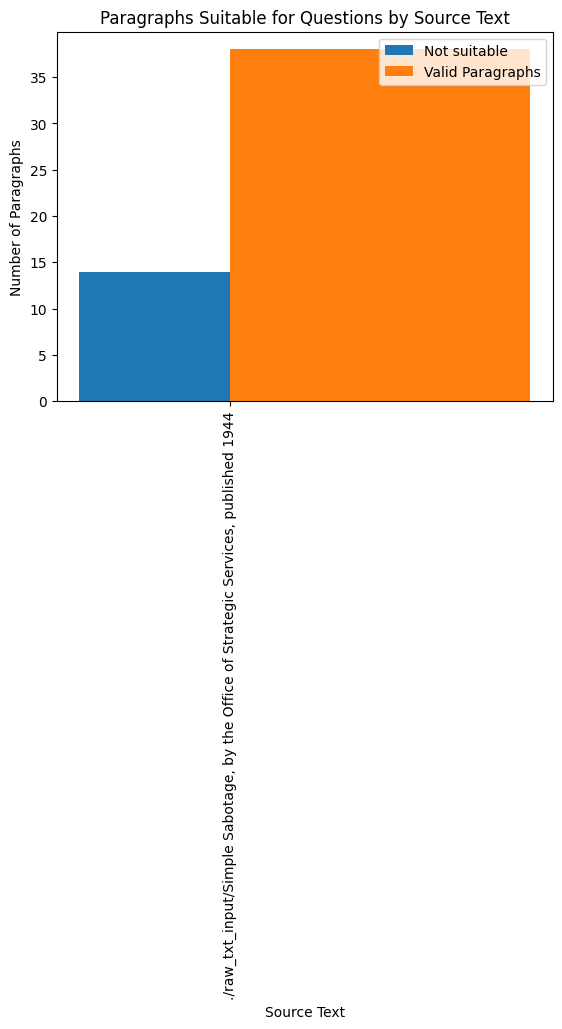

In [9]:
filtered_worthy_for_questions = control_flow_functions.filter_and_graph(judged_worthy_for_questions)

In [10]:
print(filtered_worthy_for_questions[0])

('A listing of specific acts follows, classified according to types of target. This list is presented as a growing rather than a complete outline of the methods of simple sabotage. As new techniques are developed, or new fields explored, it will be elaborated and expanded. (1) _Buildings_ Warehouses, barracks, offices, hotels, and factory buildings are outstanding targets for simple sabotage. They are extremely susceptible to damage, especially by fire; they offer opportunities to such untrained people as janitors, charwomen, and casual visitors; and, when damaged, they present a relatively large handicap to the enemy. (a) _Fires_ can be started wherever there is an accumulation of inflammable material. Warehouses are obviously the most promising targets but incendiary sabotage need not be confined to them alone. (1) Whenever possible, arrange to have the fire start after you have gone away. Use a candle and paper, combination, setting it as close as possible to the inflammable materia

### The cell below begins generating questions. SOME OF THESE MAY FAIL and have to retry due to model errors (the API branch cannot use grammars). But if you let it run you will see that the vast majority eventually get through.

In short, don't get scared by tracebacks.

In [11]:
# control flow
import json
import os
import glob

# Directory for QA tuples
qa_tuples_dir = "./qatuples_raw"
if not os.path.exists(qa_tuples_dir):
    os.makedirs(qa_tuples_dir)

# Initialize vetted_qa_tuples
vetted_qa_tuples = []  # tuple list of qa tuples that have been judged good

# Attempt to initialize filtered_worthy_for_questions
try:
    _ = filtered_worthy_for_questions
except NameError:
    filtered_worthy_for_questions = []

if not filtered_worthy_for_questions:
    # Load all files in the qa_tuples_dir if filtered_worthy_for_questions is not initialized
    existing_files = glob.glob(os.path.join(qa_tuples_dir, "*.json"))
    for file_path in existing_files:
        with open(file_path, "r") as file:
            qa_tuple = tuple(json.load(file))
            print(f"Loaded {file}")
        vetted_qa_tuples.append(qa_tuple)
else:
    tasks = [control_flow_functions.generate_qatuples_from_para(
        idx,
        para,
        engine_wrapper=engine_wrapper,
        vetted_qa_tuples=vetted_qa_tuples,
        qa_tuples_dir=qa_tuples_dir,
        double_check_counter=DOUBLE_CHECK_COUNTER,
        use_filenames=USE_FILENAMES,
        completion_mode=COMPLETION_MODE,
        logging_level=LOG_LEVEL) for idx,para in enumerate(filtered_worthy_for_questions)]
    limited_tasks_qgen = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qgen):
            await future
    

  0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
print(
    "-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):"
)
nones = list(filter(lambda x: x[0] is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa[0] is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS CREATED ------------- STATS SO FAR (may be wrong if run was continued from interruption):
Nones: 0
Non-nones: 46
Total: 46
---------------- ONTO EXAMPLES GENERATION-------------------


In [ ]:
# Check for and fix the common mistake: mentioning "the text".
writepath = "./qatuples_revised"
import json

# Assuming vetted_qa_tuples is a list that might or might not exist
try:
    _ = vetted_qa_tuples
except NameError:
    vetted_qa_tuples = []

# Load all files at the start if vetted_qa_tuples is empty
if not vetted_qa_tuples:
    # Check if the directory exists
    if os.path.exists(writepath):
        # List all files in directory
        for file_name in os.listdir(writepath):
            file_path = os.path.join(writepath, file_name)
            try: # for each file already generated, see if it succeeded or failed; if it succeeded, append its contents; if it failed, append None for stats logging
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
                    print(f"Loading file: {file_path}")
                    if content == "failed":
                        vetted_qa_tuples.append(None)
                    else:
                        try:
                            data = json.loads(content)
                            vetted_qa_tuples.append(
                                (data[0], data[1], data[2], data[3])
                            )
                        except json.JSONDecodeError:
                            print("JSON decode error with the contents:", content)
                            vetted_qa_tuples.append(None)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

else:
    old_tuples = vetted_qa_tuples.copy()
    tasks = [control_flow_functions.repair_qatuple_context(idx, tup, engine_wrapper, writepath, vetted_qa_tuples,use_filenames=USE_FILENAMES) for idx, tup in enumerate(vetted_qa_tuples)]
    limited_tasks_qcorrection = [run_task_with_limit(task) for task in tasks]
    for future in tqdmasyncio.tqdm.as_completed(limited_tasks_qcorrection): 
        await future

100%|██████████| 46/46 [00:00<00:00, 5448.84it/s]

./qatuples_revised/revised_4.json
Loaded file:
[
    "What characteristics should acts of sabotage always consist of?",
    "Acts of sabotage should always consist of acts whose results will be detrimental to the materials and manpower of the enemy.",
    "Frequently you can \u201cget away\u201d with such acts under the cover of pretending stupidity, ignorance, over-caution, fear of being suspected of sabotage, or weakness and dullness due to undernourishment. (4) After you have committed an act of easy sabotage, resist any temptation to wait around and see what happens. Loiterers arouse suspicion. Of course, there are circumstances when it would be suspicious for you to leave. If you commit sabotage on your job, you should naturally stay at your work. 4. TOOLS, TARGETS, AND TIMING  The citizen-saboteur cannot be closely controlled. Nor is it reasonable to expect that simple sabotage can be precisely concentrated on specific types of target according to the requirements of a concrete m

In [ ]:
# Print stats related to revised qatuples, and filter out nones (questions that were unanswerable due to lack of context).
import json
import os

print("-------------- QUESTIONS REVISED ------------- STATS SO FAR:")
nones = list(filter(lambda x: x is None, vetted_qa_tuples))
print(f"Nones: {len(nones)}")
print(f"Non-nones: {len(vetted_qa_tuples) - len(nones)}")
print(f"Total: {len(vetted_qa_tuples)}")
# filter out all None values
vetted_qa_tuples = [qa for qa in vetted_qa_tuples if qa is not None]
print("---------------- ONTO EXAMPLES GENERATION-------------------")

-------------- QUESTIONS REVISED ------------- STATS SO FAR:
Nones: 3
Non-nones: 43
Total: 46
---------------- ONTO EXAMPLES GENERATION-------------------


In [ ]:
qa_tuples_by_paragraph = control_flow_functions.group_by_text(vetted_qa_tuples)

In [ ]:
import os

if not os.path.exists(multi_turn_convs_info_dir):
    os.makedirs(multi_turn_convs_info_dir)

In [ ]:
import json
import random
import itertools

multi_turn_convs_info = []


tasks = [control_flow_functions.create_info(idx,group,engine_wrapper, ASSISTANT_MODE, multi_turn_convs_info,multi_turn_convs_info_dir, rearrangements_to_take=REARRANGEMENTS_TO_TAKE,use_filenames=USE_FILENAMES, completion_mode=COMPLETION_MODE, logging_level=LOG_LEVEL) for idx,group in enumerate(qa_tuples_by_paragraph)]
limited_tasks_infocreation = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_infocreation):
    await future

100%|██████████| 11/11 [00:00<00:00, 5696.67it/s]

Skipped generating ./multi_turn_convs_info/info_1_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_1_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_1_2.json as it already exists
Skipped generating ./multi_turn_convs_info/info_4_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_4_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_4_2.json as it already exists
Skipped generating ./multi_turn_convs_info/info_8_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_8_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_8_2.json as it already exists
Skipped generating ./multi_turn_convs_info/info_3_0.json as it already exists
Skipped generating ./multi_turn_convs_info/info_3_1.json as it already exists
Skipped generating ./multi_turn_convs_info/info_3_2.json as it already exists
Skipped generating ./multi_turn_convs_info/info_7_0.json as it a

### No notebook restart needed for the API notebook!

### BUT You still might've separated your generations into large and small models, so we reinitialize the engine wrapper

In [ ]:
# Initialize API Client
engine_wrapper = EngineWrapper(model=LARGE_LOGICAL_MODEL,api_key=API_KEY,base_url=BASE_URL)

In [ ]:
import os
import json

convs_info = control_flow_functions.read_json_files_info(multi_turn_convs_info_dir)

In [ ]:
import os
import json
import random
import itertools
import asyncio

multi_turn_convs_dir = "./multi_turn_convs"
if not os.path.exists(multi_turn_convs_dir):
    os.makedirs(multi_turn_convs_dir)

multi_turn_convs = []

tasks = [control_flow_functions.create_conversation(idx,info, engine_wrapper, multi_turn_convs, multi_turn_convs_dir, assistant_mode=ASSISTANT_MODE, completion_mode=COMPLETION_MODE, logging_level=LOG_LEVEL) for idx,info in enumerate(convs_info)]
limited_tasks_convwriting = [run_task_with_limit(task) for task in tasks]
for future in tqdmasyncio.tqdm.as_completed(limited_tasks_convwriting):
    await future

  0%|          | 0/31 [00:00<?, ?it/s]

No name found, retrying with different regex
Extracted name: Eleanor Pemberton
No name found, retrying with different regex
Extracted name: Eleanor Pemberton
No name found, retrying with different regex
Extracted name: Eleanor Pemberton
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
No name found, retrying with different regex
Extracted name: Harold Reynolds
No name found, retrying with different regex
Extracted name: Harold Reynolds
No name found, retrying with different regex
Extracted name: Harold Reynolds
No name found, retrying with different regex
Extracted name: Adeline Duvalier
No name found, retrying with different regex
Extracted name: Adeline Duvalier
No name found, retrying with different regex
Extract

2024-02-09 18:04:35,277 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/9dacbd22-f07e-4df7-a033-e3c695946731.txt
Answer 1: \"Fine, fine. Ask away, but don't expect me to hold your hand through every little detail. I've got work to do.\" George says, his voice remaining calm and collected as ever. \"What should a saboteur never do?\" does not match the corresponding answer in qatuples: A saboteur should never attack targets beyond their capacity or the capacity of their instruments. An inexperienced person should not, for example, attempt to use explosives, but should confine himself to the use of matches or other familiar weapons., miliar weapons.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: George Clemens
No name found, retrying with different regex
Extracted name: George Clemens


2024-02-09 18:04:37,951 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/b3a6d7de-040e-4fd3-ada6-481fc5458574.txt
Answer 3: \"Of course, dear young man,\" Sister Maria Agnes replies with a warm smile, her kind eyes radiating a gentle but firm resolve. \"Ask away, and may the Holy Spirit guide your path.\" does not match the corresponding answer in qatuples: The text prioritizes sabotage acts that have direct and immediate effects over sabotage that has widespread but indirect and delayed effects because such acts can have a more significant and immediate impact on the enemy's operations., y's operations.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Sister Maria Agnes
No name found, retrying with different regex
Extracted name: Sister Maria Agnes


2024-02-09 18:04:38,210 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
  3%|▎         | 1/31 [00:23<11:50, 23.69s/it]

Output written to ./output/multiturn_conversation_generations/a624895f-d234-41ab-a930-d62e6f3970d3.txt


2024-02-09 18:04:39,745 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/b610d34d-08c6-47ed-b13a-be20bfc90560.txt
Answer 1: \"So... so I... I shouldn't feel so guilty all the time, then...\" Amy's voice is barely above a whisper, as if she's afraid of her own words. \"It's just... it's just...\" She trails off, her voice catching in her throat. \"But... what about the other part of the text?\" She asks, looking up at her contact with hopeful, tear-filled eyes. does not match the corresponding answer in qatuples: The text suggests committing acts for which you might be blamed directly only rarely, and as long as you have a plausible excuse. The saboteur should also be profuse in their apologies., heir apologies.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Amelia 
No name found, retrying with different regex
Extracted name: Amelia 


2024-02-09 18:04:42,596 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/2ae99a37-dad8-4a94-9e23-40d5f635cfcb.txt
Answer 2: \"Attaboy,\" Rick says, a hint of approval creeping into his voice. \"Now, onto the next question: Which specific indirect methods can be used to communicate the psychological tactic of highlighting that the saboteur is part of a larger group of saboteurs?\" does not match the corresponding answer in qatuples: Potential saboteurs should be made to anticipate indirect personal gain such as enemy evacuation or destruction of the ruling government group., vernment group.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Richard 
No name found, retrying with different regex
Extracted name: Richard 


2024-02-09 18:04:43,104 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/aae347ec-de62-4dd0-b98b-7736db485ac3.txt
First question does not contain a part of the question from tuples. Validation failed!
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Adeline Duvalier
No name found, retrying with different regex
Extracted name: Adeline Duvalier


2024-02-09 18:04:43,537 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/5a96fac3-52a3-4908-bdbd-1c600b24540a.txt
Conversation is too short! Validation failed!
[('Sister Maria Dolores', '\\"Greetings, sister,\\" Sister Maria Dolores begins, her stern, uncompromising facial expression softening slightly as she looks at the other nun standing in front of her, her hands clasped in front of her. \\"I must say, I am rather surprised to see you here in my private quarters. We are, after all, in the middle of a war, and it would be best for you to return to your own quarters as soon as possible. Now, what might you want from me?\\"'), ('Other Nun', '\\"I... uh... I was just reading this pamphlet about this... this \'simple sabotage\', Sister Maria,\\" the other nun, stammering and blushing, hands the pamphlet to Sister Maria. \\"I was just wondering... how does simple sabotage function as a weapon against the enemy?\\"'), ('Sister Maria Dolores', '\\"My dear sister,\\" Sister Maria Dolores replies, her 

2024-02-09 18:04:44,855 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
  6%|▋         | 2/31 [00:30<06:36, 13.67s/it]

Output written to ./output/multiturn_conversation_generations/9071aa9f-8d11-4c4d-b949-dc2407043044.txt


2024-02-09 18:04:45,128 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 18:04:45,190 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/ca02dd95-6e0e-4064-8945-670b3510e5a2.txt
Conversation is too short! Validation failed!
[('Agnes Thompson', '\\"Oh, hello there, child! You\'re just as bright-eyed and bushy-tailed as a squirrel, aren\'t you?\\" Agnes greets Emily with a warm smile, a friendly twinkle in her eyes. \\"Now,\\" she continues, her voice gentle and melodious, \\"what type of books are you looking for today? Are you interested in reading some adventure books?\\" She asks, adjusting the frames of her glasses, slightly fumbling with them, a nervous habit of hers. \\"I always love helping young people find the books they\'re looking for, especially when they\'re interested in adventure books, just like my own dear daddy used to love reading them too!\\"'), ('Emily', '\\"Oh, uh, well...\\" Emily fidgets with her skirt nervously, her eyes darting back and forth as she gathers her courage. \\"Actually, ma\'am, I... well, the truth is that I love reading 

2024-02-09 18:04:45,431 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 10%|▉         | 3/31 [00:30<03:35,  7.69s/it]

Output written to ./output/multiturn_conversation_generations/f613442a-b00b-44a4-844b-c3851e845caf.txt
Found her lipstick-colored lips in the conversation!


2024-02-09 18:04:45,649 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
2024-02-09 18:04:45,833 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/b1284a6d-5c8e-4b42-92b8-45f93d8f609a.txt
Answer 2: \"T-The text differentiates the two extreme types of potential citizen-saboteurs by explaining that: 1the man who is not technically trained and employed, and 2) the man who is a technician, such as a lathe operator or an automobile mechanic.\" Agnes blushes even harder, her face now a bright red. She then has to pause and compose herself, nervously fiddling with her glasses as she tries to steady her nerves. \"I-I'm sorry, s-sir. I-I...\" She looks down at her hands, fidgeting nervously. \"I-I... I-I wanted to make sure I was providing the most accurate and thorough information possible for you, sir.\" does not match the corresponding answer in qatuples: The Straightforward Saboteur needs specific suggestions as to what he can and should destroy, as well as details regarding the tools by means of which destruction is accomplished. On the other hand, the Technically Versed S

2024-02-09 18:04:47,174 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/aa5569a1-7f03-43d2-8a05-7b912239b60b.txt
Answer 1: \"Dear,\" Margaret says, her voice filled with a stern, disapproving tone, \"our members' backgrounds are not something we discuss openly, for it is a breach of their privacy. However, I can tell you that all our members are upstanding women who share our circle's values and commitment to our community. As for myself, I am a devoted wife and mother, and I run this knitting circle to give our town a sense of unity and purpose.\" Margaret's eyes gleam with a fierce determination as she speaks. does not match the corresponding answer in qatuples: The text suggests committing acts for which you might be blamed directly only rarely, and as long as you have a plausible excuse. The saboteur should also be profuse in their apologies., heir apologies.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
No name foun

2024-02-09 18:04:47,835 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 13%|█▎        | 4/31 [00:33<02:31,  5.60s/it]

Output written to ./output/multiturn_conversation_generations/fc84a238-4cf1-4e25-820f-3743623ae24f.txt


2024-02-09 18:04:48,594 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/044d4416-8860-44b2-bf6d-b43f86a3311b.txt
Conversation contains unintended repeated quotes. Validation failed!
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Amelia 
No name found, retrying with different regex
Extracted name: Amelia 


2024-02-09 18:04:49,599 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 16%|█▌        | 5/31 [00:35<01:49,  4.22s/it]2024-02-09 18:04:49,623 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/4fd4b317-9cca-4fa9-a859-d99d0154b1fd.txt
Output written to ./output/multiturn_conversation_generations/b848a9b9-4503-4efc-a6f0-0036de9ecb38.txt
Each question does not contain a part of the question from tuples. Validation failed!
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Amelia 'Mia' LeBlanc
No name found, retrying with different regex
Extracted name: Amelia 'Mia' LeBlanc


2024-02-09 18:04:49,895 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/2c16cee7-c402-4c95-a1c9-76df0173825c.txt
Answer 1: \"Oh, um... simple sabotage?\" Esther stammers, her eyes wide with surprise and fear. \"I-I don't know much about that, but if it's for the good of our great country, then I-I will try my best to help you understand it. I-I just hope I can be of some assistance. So um... what was your first question?\" she asks, her voice trembling slightly. does not match the corresponding answer in qatuples: Among the media which may be used, as the immediate situation dictates, are: freedom stations or radio false broadcasts or leaflets, which may be directed toward specific geographic or occupational areas, or they may be general in scope., neral in scope.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Esther Banks
No name found, retrying with different 

2024-02-09 18:04:50,907 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 19%|█▉        | 6/31 [00:36<01:20,  3.23s/it]

Output written to ./output/multiturn_conversation_generations/9ac5f3ae-5639-4ed7-b625-e3eafc2ad099.txt


2024-02-09 18:04:52,065 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 23%|██▎       | 7/31 [00:37<01:01,  2.55s/it]

Output written to ./output/multiturn_conversation_generations/22a91b90-eb23-4bae-b1ac-412eceef5aff.txt


2024-02-09 18:04:53,163 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 26%|██▌       | 8/31 [00:38<00:48,  2.09s/it]

Output written to ./output/multiturn_conversation_generations/4cdeddfa-d09a-4f55-bbfa-a476bba7de40.txt


2024-02-09 18:04:54,259 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/76343aba-28f6-45d5-8f23-f243e5bbe299.txt
Answer 1: \"Ahh, darling, you're so sweet,\" Amy purrs, her voice like silk as it wraps around James. \"But I must say, I'm not one to turn down a good bottle of bubbly. So go on, and fetch us some. I'll be waiting right here for you, my champagne connoisseur.\" She winks again, her lips painted a sultry shade of red. does not match the corresponding answer in qatuples: Buildings such as warehouses, barracks, offices, hotels, and factory buildings are susceptible to simple sabotage because they are very prone to damage, especially by fire. This damage can be easily caused by untrained people such as janitors, charwomen, and casual visitors., asual visitors.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Amelia 
No name found, retrying with different r

2024-02-09 18:04:54,749 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/e16a6a31-8ba4-4c82-b435-a88ef15d47d2.txt
First question does not contain a part of the question from tuples. Validation failed!
----------------



RETRYING!!!!



----------------
No name found, retrying with different regex
Extracted name: Olivia Moreno
No name found, retrying with different regex
Extracted name: Olivia Moreno


2024-02-09 18:04:55,082 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 29%|██▉       | 9/31 [00:40<00:44,  2.04s/it]

Output written to ./output/multiturn_conversation_generations/85ecaa78-4b17-4026-9c5c-6a4ffc3c1edd.txt


2024-02-09 18:04:58,239 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 32%|███▏      | 10/31 [00:43<00:49,  2.38s/it]

Output written to ./output/multiturn_conversation_generations/aa5569a1-7f03-43d2-8a05-7b912239b60b.txt
Conversation is too short! Validation failed!
[('Margaret Dawson', '\\"Welcome, Sarah,\\" Margaret begins, her voice stern and her posture unyielding, as if she were a statue of a strict woman. \\"I am Margaret Dawson, the knitting circle leader here in our quaint little town. We gather here to share our love of knitting and to create a sense of community and togetherness. We also aim to promote the importance of upholding traditional values, as one can see from the beautiful, intricate patterns we create in our knitting.\\" She pauses, her eyes glinting with disapproval. \\"But I must say, it is rather unorthodox for you to introduce yourself to me like this... one should always show the proper respect to their elders and superiors, you know. Nonetheless, you are one of us now, so you are welcome here.\\"'), ('Sarah', '\\"I\'m truly sorry for any disrespect I may have shown, Margaret

2024-02-09 18:04:58,898 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 35%|███▌      | 11/31 [00:44<00:37,  1.86s/it]2024-02-09 18:04:59,082 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/6e4c23eb-d31a-4899-bdcb-e8d5e65cb647.txt
Output written to ./output/multiturn_conversation_generations/1dba0ed3-ec47-42b8-9203-0415506d37e0.txt
Answer 3: \"Oh, do you now?\" Harold says, stopping in his tracks and turning around to face Barbara again. \"And what question could that possibly be, hmm?\" does not match the corresponding answer in qatuples: The optimal conditions for igniting a fire using a candle and paper are as follows: Tear a strip three or four centimeters wide from a sheet of paper, wrap it around the base of the candle two or three times, and twist more sheets of paper into loose ropes and place them around the base of the candle. The size, heat, and duration of the resulting flame will depend on how much paper you use and how much of it you can cramp in a small space.,  a small space.
Answers in dialogues do not match corresponding answers in qatuples.
----------------



RETRYING!!!!



----------------

2024-02-09 18:04:59,920 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 39%|███▊      | 12/31 [00:45<00:30,  1.60s/it]2024-02-09 18:04:59,978 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/27aeac16-3736-44df-831c-b1dbd2421aeb.txt
Output written to ./output/multiturn_conversation_generations/3c61dae8-9560-4381-a9f3-a89b3e063ebb.txt


2024-02-09 18:05:01,444 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/c32bbc06-45e9-4538-a229-18f2a1986998.txt
Answer 4: \"Of course, Oliver,\" Amy says, standing up as well, her red lips curving into a coy smile. \"Now, remember what we talked about today, alright? I'd hate to see you slipping up in the field due to carelessness.\" She then winks at him, her eyes sparkling with mischief. \"And as for our next rendezvous... well, I guess you'll just have to wait and see, won't you?\" She says, her voice low and seductive, as she turns around and begins to walk away, leaving Oliver standing there alone, his thoughts both exhilarated and utterly bewildered by the whirlwind encounter with the enigmatic spy. does not match the corresponding answer in qatuples: The potential risk of sabotage can affect the conditions under which sabotage can be effectively carried out by necessitating more caution and discretion. This might involve avoiding loitering after acts of sabotage and being aware of circum

2024-02-09 18:05:04,121 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 45%|████▌     | 14/31 [00:49<00:31,  1.83s/it]

Output written to ./output/multiturn_conversation_generations/b3a6d7de-040e-4fd3-ada6-481fc5458574.txt
Conversation is too short! Validation failed!
[('Sister Maria Agnes', '\\"May the Lord\'s peace be with you, my son,\\" Sister Maria Agnes says kindly, looking up from her knitting as Carlos enters the convent\'s modest but cozy parlour. \\"You are most certainly... welcome here.\\" She smiles softly, her eyes warm with compassion. \\"I hope you have come seeking some guidance, is that?\\"'), ('Carlos', '\\"Yes, Sister Maria,\\" Carlos says, speaking with nervous urgency. \\"I...\\" He takes a deep breath, trying to calm himself down, \\"I\'ve been trying to...\\" He clenches his fists, feeling the weight of the war pressing down on his shoulders. \\"I\'ve been trying to help those who are fighting against the enemy, and I need to know...\\" Carlos swallows hard, his throat dry. \\"What does the text suggest as potential targets for simple sabotage?\\"'), ('Sister Maria Agnes', '\\"Th

2024-02-09 18:05:06,309 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 48%|████▊     | 15/31 [00:51<00:30,  1.92s/it]

Output written to ./output/multiturn_conversation_generations/9dacbd22-f07e-4df7-a033-e3c695946731.txt
Answer 4: \"How is a saboteur advised to choose their targets?\" does not match the corresponding answer in qatuples: A saboteur is advised to damage only objects and materials known to be in use by the enemy or to be destined for early use by the enemy. The saboteur can assume that almost any product of heavy industry is destined for enemy use, and that the most efficient fuels and lubricants also are destined for enemy use. However, they should not attempt destruction of food crops or food products without special knowledge., cial knowledge.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-09 18:05:06,828 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 52%|█████▏    | 16/31 [00:52<00:23,  1.57s/it]

Output written to ./output/multiturn_conversation_generations/2ae99a37-dad8-4a94-9e23-40d5f635cfcb.txt
Conversation is too short! Validation failed!
[('Richard \\"Rick\\" Thompson', '\\"New recruit, huh? Well, welcome to the resistance\'s headquarters. I\'m Rick, one of the strategists here. You\'ve got a lot of questions, and I\'m going to give you a lot of answers. Now, are you ready to learn about the psychological tactics we use to fight against the enemy occupation?\\"'), ('New Recruit', '\\"Yes, sir! I want to do everything I can to help the resistance. Please, teach me about these psychological tactics!\\"'), ('Richard \\"Rick\\" Thompson', '\\"Alright, alright, let\'s not get too excited, shall we? We\'ve got a job to do, and we\'re going to see it through, no matter what. Now, the first question you asked was about \'anticipating indirect personal gain\'. How is this psychological tactic communicated to potential saboteurs? Here\'s the answer: The psychological tactic of \'ant

2024-02-09 18:05:08,025 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 55%|█████▍    | 17/31 [00:53<00:20,  1.45s/it]

Output written to ./output/multiturn_conversation_generations/5a96fac3-52a3-4908-bdbd-1c600b24540a.txt


2024-02-09 18:05:08,317 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 58%|█████▊    | 18/31 [00:53<00:14,  1.12s/it]

Output written to ./output/multiturn_conversation_generations/0d826d09-a0ee-4950-adbb-1ea0dd46be5e.txt
Each question does not contain a part of the question from tuples. Validation failed!


2024-02-09 18:05:09,851 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 61%|██████▏   | 19/31 [00:55<00:14,  1.24s/it]

Output written to ./output/multiturn_conversation_generations/b610d34d-08c6-47ed-b13a-be20bfc90560.txt
Answer 3: \"I understand.\" Amy's voice is soft-spoken and timid, as if she's afraid of her own words. \"I... I will do my best with what I have been given. I... I won't let you down.\" Amy's eyes glisten with unshed tears as she speaks, her voice barely above a whisper. \"I... I just hope that one day, this war will be over, and I'll be able to find some peace and redemption for myself.\" does not match the corresponding answer in qatuples: The text lists items such as a knife or a nail file, matches, pebbles, hair, salt, nails, wrenches, hammers, emery paper, and air raid as objects that can be used as a multi-purpose instrument for creating damage., reating damage.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-09 18:05:11,796 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 65%|██████▍   | 20/31 [00:57<00:15,  1.45s/it]

Output written to ./output/multiturn_conversation_generations/b1284a6d-5c8e-4b42-92b8-45f93d8f609a.txt


2024-02-09 18:05:12,718 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"


Output written to ./output/multiturn_conversation_generations/6a994c42-ca10-46ab-bb19-86eb23bf9792.txt
Answer 1: \"Of course... um... I-I-I... um... would be... um... 'happy'... um... to share... um... my knowledge with you, fellow saboteur... um... sorry... um... if... um... that's... um... too much information... um... for you...\" Arthur nervously clears his throat, looking around the dimly lit safehouse. \"U-u-um, so... um... if... um... you're ready to... um... learn from me... um... then... um... please go ahead and... um... ask your questions... um... I'll do my best... um... to answer them to the... um... best of my abilities... um... sorry... um... if... um... that's... um... too much information... um... for you...\" does not match the corresponding answer in qatuples: The text provides three suggestions: use materials that appear innocent, commit acts for which large numbers of people could be responsible, and do not be afraid to commit acts for which you might be blamed dir

2024-02-09 18:05:16,066 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 68%|██████▊   | 21/31 [01:01<00:22,  2.27s/it]

Output written to ./output/multiturn_conversation_generations/e16a6a31-8ba4-4c82-b435-a88ef15d47d2.txt
Answer 2: \"Ah, my dear James,\" Olivia coos, her sultry voice like the sweetest of siren songs. \"The suggested communication can indirectly convey the idea of being part of a larger group of saboteurs by including observations that a particular technique has been successful in this or that district.\" She gently caresses James' hand, her long black hair cascading over her shoulders and framing her dangerously beautiful face. \"Even if the technique is not applicable to their surroundings, another's success will encourage them to attempt similar acts.\" She suddenly pulls back, her eyes flashing with a dangerous light. \"Do you understand what I'm saying to you, my dear?\" does not match the corresponding answer in qatuples: The psychological tactic of 'anticipating indirect personal gain' is communicated to potential saboteurs by stating gains as specifically as possible for the are

2024-02-09 18:05:16,854 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 71%|███████   | 22/31 [01:02<00:16,  1.83s/it]

Output written to ./output/multiturn_conversation_generations/aae347ec-de62-4dd0-b98b-7736db485ac3.txt


2024-02-09 18:05:17,422 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 74%|███████▍  | 23/31 [01:02<00:11,  1.46s/it]

Output written to ./output/multiturn_conversation_generations/2c16cee7-c402-4c95-a1c9-76df0173825c.txt
Answer 1: \"Thank you... I-I really appreciate it,\" Charles says, relief flooding into his voice now that he's gotten Esther's consent, \"I-I really am trying to learn as much as I can about simple sabotage. I was wondering, what are the different media that might be used to disseminate information regarding simple sabotage?\" does not match the corresponding answer in qatuples: Among the media which may be used, as the immediate situation dictates, are: freedom stations or radio false broadcasts or leaflets, which may be directed toward specific geographic or occupational areas, or they may be general in scope., neral in scope.
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-09 18:05:18,595 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 77%|███████▋  | 24/31 [01:04<00:09,  1.37s/it]

Output written to ./output/multiturn_conversation_generations/76343aba-28f6-45d5-8f23-f243e5bbe299.txt
First question does not contain a part of the question from tuples. Validation failed!


2024-02-09 18:05:19,680 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 81%|████████  | 25/31 [01:05<00:07,  1.29s/it]

Output written to ./output/multiturn_conversation_generations/4f47d999-bbaf-4e2a-befb-2b6c56ad17e1.txt
Answer 1: \"Hmph... guidance from me, you say?\" Martha's lips curl into a disapproving frown. \"Very well then. I suppose I can spare a few moments for you. But I must warn you, I expect you to put what I tell you to good use. Now then, I believe you had a question for me?\" does not match the corresponding answer in qatuples: The specific indirect method to communicate this psychological tactic is by including suggestions which they read and hear, such as observations that a particular technique has been successful in this or that district.\n\"\"\", strict.\n\"\"\"
Answers in dialogues do not match corresponding answers in qatuples.


2024-02-09 18:05:24,613 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 84%|████████▍ | 26/31 [01:10<00:11,  2.38s/it]

Output written to ./output/multiturn_conversation_generations/b848a9b9-4503-4efc-a6f0-0036de9ecb38.txt


2024-02-09 18:05:27,846 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 87%|████████▋ | 27/31 [01:13<00:10,  2.63s/it]

Output written to ./output/multiturn_conversation_generations/ca02dd95-6e0e-4064-8945-670b3510e5a2.txt


2024-02-09 18:05:28,392 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 90%|█████████ | 28/31 [01:13<00:06,  2.01s/it]

Output written to ./output/multiturn_conversation_generations/c32bbc06-45e9-4538-a229-18f2a1986998.txt
First question does not contain a part of the question from tuples. Validation failed!


2024-02-09 18:06:03,616 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 94%|█████████▎| 29/31 [01:49<00:23, 11.96s/it]

Output written to ./output/multiturn_conversation_generations/6a994c42-ca10-46ab-bb19-86eb23bf9792.txt
Answer 1: \"O-o-okay, um... I... um... I'll... um... try to... um... do my best to... um... explain to you... um... the... um... 'best practices' of... um... sabotage, Sandy, um... sorry... um... if... um... that's... um... too much information... um... for you...\" Arthur looks down at his small notebook, staring at its blank pages as if seeking guidance from them. \"I-I-I'm... um... just... um... trying to... um... help you... um... Sandy... um... in... um... this... um... 'sharing of knowledge'... um... sorry... um... if... um... that's... um... too much information... um... for you...\" does not match the corresponding answer in qatuples: The text provides three suggestions: use materials that appear innocent, commit acts for which large numbers of people could be responsible, and do not be afraid to commit acts for which you might be blamed directly, as long as you do so rarely, 

2024-02-09 18:06:28,660 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 524 "
2024-02-09 18:06:28,662 - INFO - Retrying request to /chat/completions in 0.917432 seconds
2024-02-09 18:06:39,116 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 524 "
2024-02-09 18:06:39,119 - INFO - Retrying request to /chat/completions in 0.980206 seconds
2024-02-09 18:06:50,613 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
 97%|█████████▋| 30/31 [02:36<00:22, 22.46s/it]

Output written to ./output/multiturn_conversation_generations/044d4416-8860-44b2-bf6d-b43f86a3311b.txt
Conversation is too short! Validation failed!
[('Amelia Clarke', '\\"Charles, a colleague of mine, it seems. Sit down,\\" She says, her eyes never leaving him as she gestures to a chair opposite her. \\"Tell me, how much do you actually know about me?\\" She asks, her voice dangerously calm, a small, barely noticeable smile playing at the corners of her lips. \\"I trust you about as much as I trust a viper not to strike at me.\\"'), ('Charles', 'Charles, with a forced smile on his face and a hint of annoyance in his tone, takes a seat in front of Amy. \\"Well, alright then, since you\'re so interested in me, let\'s switch things around and start with me instead. What aspects of buildings make them susceptible to simple sabotage, and what types of untrained people can easily carry out such acts in those buildings?\\"'), ('Amelia Clarke', '\\"Buildings such as warehouses, barracks, offi

2024-02-09 18:07:20,616 - INFO - HTTP Request: POST https://api.together.xyz/chat/completions "HTTP/1.1 200 OK"
100%|██████████| 31/31 [03:06<00:00,  6.00s/it]

Output written to ./output/multiturn_conversation_generations/1dba0ed3-ec47-42b8-9203-0415506d37e0.txt
Conversation is too short! Validation failed!
[('Harold Reynolds', '\\"Ah, a new face in the factory, eh? I\'m Harold Reynolds, the man who makes sure everything runs smoothly around here. Or at least, I try to. But let\'s be honest here, the people around me? They\'re just a bunch of lazy, incompetent, useless sacks. I\'m the only one around here who actually knows how to do his job right. But, ah, enough about me, let\'s talk about you. So, what brings you to this fine establishment?\\" Harold flashes a smug, self-satisfied smile as he speaks, as if he\'s taking great pleasure in the misery and destruction that his knowledge can bring about. \\"But anyway, you want to know more about me? Well, I\'m a mid-level manager here at the factory. I make sure the workers do their jobs right, and I make sure they know it when they don\'t. I\'m not one to mince words, you know. I\'m a man of a

# Yay! Now you have a dataset!
### GPT wrote the cell below. I think it successfully converts things to ShareGPT format for use with axolotl, but I am not sure because I don't know that format very well and haven't used Axolotl. However, the json produced by the second function looks fine.

In [ ]:
import os
import json

# Make ShareGPT-format dataset (I think, still need verification it actually works)
control_flow_functions.convert_directory_to_list("./multi_turn_convs/")
# Make dataset in a format that has all the information. See README for details on this format.
control_flow_functions.convert_directory_and_process_conversations("./multi_turn_convs/")

No name found, retrying with different regex
Extracted name: Abigail Hawthorne
No name found, retrying with different regex
Extracted name: Sister Maria Dolores
No name found, retrying with different regex
Extracted name: Edith Lancaster
No name found, retrying with different regex
Extracted name: Isabella Delgado
No name found, retrying with different regex
Extracted name: Agnes Thompson
No name found, retrying with different regex
Extracted name: Adeline Duvalier
No name found, retrying with different regex
Extracted name: Viktor Petrov
No name found, retrying with different regex
Extracted name: Agnes St. Claire
No name found, retrying with different regex
Extracted name: Amelia 'Mia' LeBlanc
No name found, retrying with different regex
Extracted name: Lilya Petrova
No name found, retrying with different regex
Extracted name: Eleanor Pemberton
No name found, retrying with different regex
Extracted name: Elena 'Lena' Volkov
No name found, retrying with different regex
Extracted name:

In [ ]:
with open("./processed_master_list.json") as f:
    first = f.read()
    data = json.loads(first)

In [ ]:
# For curiosity's sake, you can find out how many lines of dialogue you generated
def filter_and_flatten(lst):
    # Initialize an empty list to hold the flattened elements
    flat_list = []

    # Loop through each sublist in the main list
    for sublst in lst:
        # Check if the first element of the sublist is itself a list (subsublist1)
        if isinstance(sublst[0], list):
            # Extend the flat_list with the elements from subsublist1
            flat_list.extend(sublst[0])

    return flat_list


len(filter_and_flatten(data))

157